**<h3><center>EN2550 Assignment 2-Fitting and Alignment</center></h3>**
*Name - Abeysinghe W.A.M.S.Y*
<br>
*Index no - 190014F*
<br>

All the imports are done at the beginning. 

In [1]:
import numpy as np
import cv2 as cv
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import circle_fit as cf

**Q1**. The code snippet in Listing 1 shows the code to generate a noisy point set X amounting to a circle and the
code to estimate a circle—center and the radius—from a set of inliers in X.

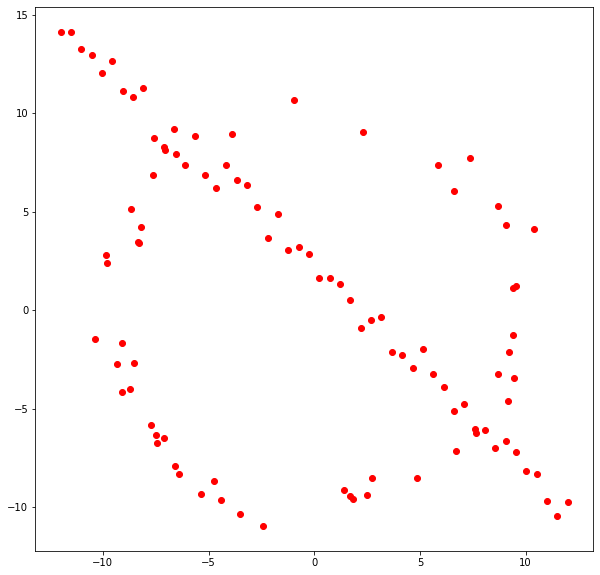

In [2]:
np.random.seed(0)
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r + n)*np.cos(t), (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n , 1) ,y.reshape(half_n, 1 ) ) )
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(X_circ[:,0], X_circ[:,1], 'ro')
ax.plot(X_line[:,0], X_line[:,1], 'ro')

plt.show()

(a) Estimate the circle using the RNASAC algorithm

In [3]:
#Getting the circle given three points that it should lie on.

def circ_through_points(x1, x2, x3):
    denominator_1 = ( (x1[0] - x2[0]) * (x2[1] - x3[1]) - (x2[1] - x1[1]) * (x3[0] - x2[0]) )
    denominator_2 = ( (x1[0] - x2[0]) * (x2[1] - x3[1]) - (x2[1] - x1[1]) * (x3[0] - x2[0]) )

    if denominator_1 != 0 and denominator_2 != 0:
        a = 0.5 * ( (x2[1] - x3[1]) * (x1[0]**2 + x1[1]**2 - x2[0]**2 - x2[1]**2) + (x2[1] - x1[1]) * (x2[0]**2 + x2[1]**2 - x3[0]**2 - x3[1]**2) ) / denominator_1
        b = 0.5 * ( (x1[0] - x2[0]) * (x2[0]**2 + x2[1]**2 - x3[0]**2 - x3[1]**2) + (x3[0] - x2[0]) * (x1[0]**2 + x1[1]**2 - x2[0]**2 - x2[1]**2) ) / denominator_2
        c = -x3[0]**2 - x3[1]**2 + 2*a*x3[0] + 2*b*x3[1]

        r = np.sqrt(a**2 + b**2 - c)
    else:
        a,b,r = None, None, None

    return a, b, r

In [4]:
#Calculating the inliers when T, the threshold is given

def get_inlier(a, b, r, X, T):
    count = 0
    best_fit_inliers = None

    for i in range(X.shape[0]):
        distance = abs( ( (X[i,0] - a)**2 + (X[i,1] - b)**2 ) ** 0.5 - r )

        if distance < T:
            count += 1

            if type(best_fit_inliers) == type(None):
                best_fit_inliers = np.array([X[i,:]])
            else:
                best_fit_inliers = np.concatenate((best_fit_inliers, X[i,:].reshape(1, -1)), axis=0)
    
    return count, best_fit_inliers

In [5]:
def RANSAC(X): 
    S = 3
    T = 1.96
    D = 50
    N = 35

    best_fit_circle = None
    best_fit_x = None
    best_inlier_count = 0

    for _ in range(N):
        x = []

        for i in range(S):
            hold = X[np.random.randint(0, 100), :]
            
            if len(x) == 0:
                x.append(hold)
            elif np.array_equal(hold, x[-1]):                
                while np.array_equal(hold, x[-1]):
                    hold = X[np.random.randint(0, 100), :]
                
                x.append(hold)
            else:
                x.append(hold)
        
        a, b, r = circ_through_points(x[0], x[1], x[2])

        if a == None:
            continue

        count, inliers = get_inlier(a, b, r, X, T)

        if count > best_inlier_count:
            best_fit_circle = plt.Circle((a, b), r, color='b', fill=False, label="Best Sample")
            best_fit_x = x
            best_fit_inliers = inliers
            best_inlier_count = count
    
    if best_inlier_count < D:
        print("The RANSAC algorithm did not find a suitable model")
        return None, None, None, None

    xc,yc,r,_ = cf.least_squares_circle(best_fit_inliers)

    ransac_circle = plt.Circle((xc, yc), r, color='m', fill=False, label="RANSAC")
    
    return ransac_circle, best_fit_circle, best_fit_x, best_fit_inliers

(b) Show in the same plot, the point set, the circle estimated from the sample leading to the best estimate,
this sample of three points, inliers, and the best-fit circle. See Figure 1 for an example.

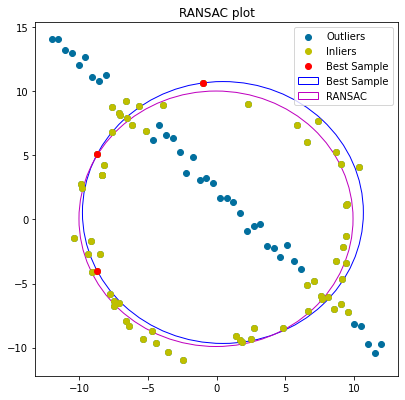

In [6]:
ransac_circle, best_fit_circle, x, inliers = RANSAC(X)


if ransac_circle != None:
    fig, ax = plt.subplots(1, 1, figsize=(6.5,6.5))
    ax.scatter(X_circ[:,0], X_circ[:,1], color="#026f9e")
    ax.scatter(X_line[:,0], X_line[:,1], color="#026f9e", label="Outliers")

    if type(inliers) != type(None):
        for point in inliers:
            if np.array_equal(point, inliers[-1]):
                ax.plot(point[0], point[1], 'yo', label="Inliers")
            else:
                ax.plot(point[0], point[1], 'yo')


    for point in x:
        if np.array_equal(point, x[-1]):
            ax.plot(point[0], point[1], 'ro', label="Best Sample")
        else:
            ax.plot(point[0], point[1], 'ro')

    ax.add_patch(best_fit_circle)
    ax.add_patch(ransac_circle)
    ax.set_title("RANSAC plot")
    ax.legend(loc="upper right")

**Q2**. Figure 2 shows an architectural image1 with a flag 2 superimposed. This is done by clicking four points on a
planar surface in the architectural image, computing a homography that maps the flag image to this plane,
and warping the flag, and blending on to the architectural image. Carry this out for a couple of image pairs
of you own choice. You may explain the (non-technical) rationale of your choice.

In [7]:
def mouse_clicks(event, x, y, flags, params):
    global coordinates
    global count
    global first_image

    if event == cv.EVENT_LBUTTONDOWN:
        coordinates.append([x, y])
        count += 1

        first_image = cv.circle(first_image, (x,y), 2, (0, 0, 1), -1)
        cv.imshow("Image", first_image)        
    
    if count == 4:
        cv.destroyAllWindows()
        cv.waitKey(1)

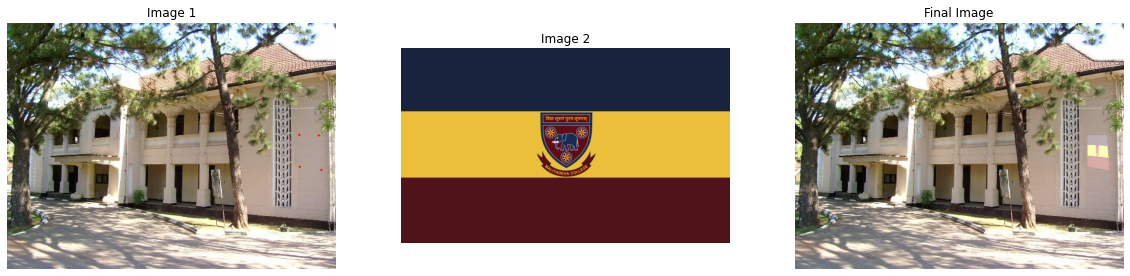

In [8]:
image_1 = cv.imread(r"school.jpg")
image_2 = cv.imread(r"Maliyadeva_flag.png")


image_1 = image_1.astype(np.float64) / np.iinfo(image_1.dtype).max

image_2 = image_2.astype(np.float64) / np.iinfo(image_2.dtype).max

first_image = np.copy(image_1)

coordinates = []
count = 0

cv.imshow("Image", image_1)
cv.setMouseCallback("Image", mouse_clicks)
cv.waitKey(0)

cv.destroyAllWindows()

# Input parameters
X = np.array([[0, 0, 1],[image_2.shape[1], 0, 1],[image_2.shape[1], image_2.shape[0], 1],[0, image_2.shape[0], 1]]).T

Y = np.array([[coordinates[0][0], coordinates[0][1], 1],[coordinates[1][0], coordinates[1][1], 1],[coordinates[2][0], coordinates[2][1], 1],[coordinates[3][0], coordinates[3][1], 1],]).T

O = np.array([[0],[0],[0]])

A = []

for i in range(4):
    A.append(np.concatenate((O.T, np.expand_dims(X.T[i,:], axis=0), np.expand_dims(-1*Y[1, i]*X.T[i,:], axis=0) ), axis=1))
    A.append(np.concatenate((np.expand_dims(X.T[i,:], axis=0), O.T, np.expand_dims(-1*Y[0, i]*X.T[i,:], axis=0) ), axis=1))

A = np.array(A).squeeze().astype(np.float64)

eigen_values, eigen_vectors = np.linalg.eig(A.T @ A)
H = eigen_vectors[:, np.argmin(eigen_values)]
H = H.reshape(3, -1)

t_image_2 = cv.warpPerspective(image_2, H, (image_1.shape[1], image_1.shape[0]))

beta = 0.5
blended_img = cv.addWeighted(image_1, 1, t_image_2, beta, 0.0)
blended_img[blended_img > 1] = 1

first_image_rgb = cv.cvtColor(first_image.astype(np.float32), cv.COLOR_BGR2RGB) 
image_2_rgb = cv.cvtColor(image_2.astype(np.float32), cv.COLOR_BGR2RGB)
blended_img_rgb = cv.cvtColor(blended_img.astype(np.float32), cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(first_image_rgb)
ax[1].imshow(image_2_rgb)
ax[2].imshow(blended_img_rgb)

ax[0].set_title("Image 1")
ax[1].set_title("Image 2")
ax[2].set_title("Final Image")

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")

plt.show()

**Q2**. In this questions, we will stitch the two Graffiti image3 img1.ppm onto img5.ppm.

(a) Compute and match SIFT features between the two images.

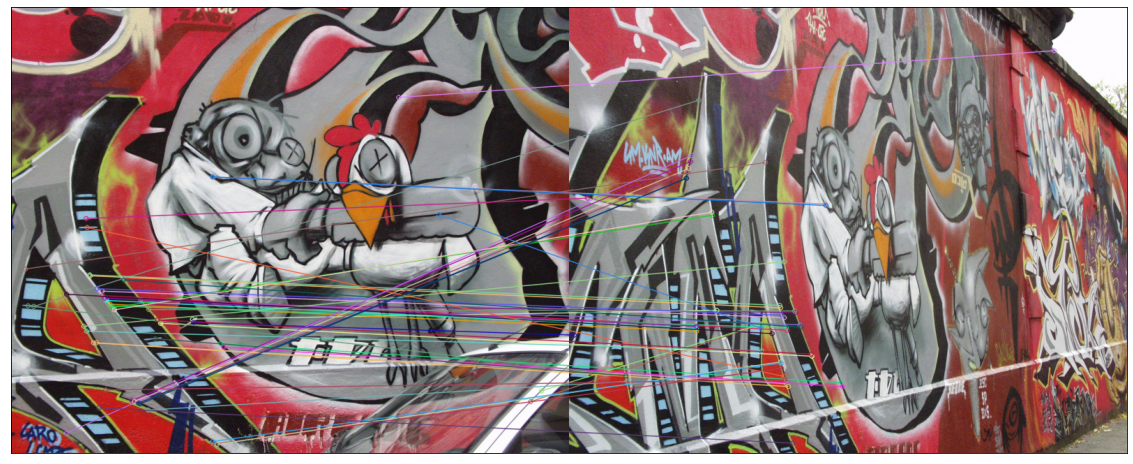

In [9]:
img1 = cv.imread('img1.ppm')
img5 = cv.imread('img5.ppm')
assert img1 is not None
assert img5 is not None

img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

sift = cv.SIFT_create(nOctaveLayers = 3, contrastThreshold = 0.1, edgeThreshold = 25, sigma = 1)
bf = cv.BFMatcher(cv.NORM_L2SQR, crossCheck=True)

key1, des1 = sift.detectAndCompute(img1_gray, None)
key5, des5 = sift.detectAndCompute(img5_gray, None)

matches = bf.match(des1, des5)
matches = sorted(matches, key=lambda x:x.distance)

out_img = cv.drawMatches(img1, key1, img5, key5, matches[:50], img5, flags=2)

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(out_img)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

(b) Compute the homography using your own code within RANSAC and compare with the homography
given in the dataset.

In [10]:
def matched_coordinates(matches, key1, key2):
    p1, p2 = [], []
    for match in matches:
        k1_index = match.queryIdx
        k2_index = match.trainIdx
        point1 = key1[k1_index].pt
        point2 = key2[k2_index].pt
        p1.append(point1)
        p2.append(point2)
    return np.array(p1, dtype=np.float32), np.array(p2, dtype=np.float32)

In [11]:
def inliers(H, points1, points2, thresh_dis):
    count = 0
    inl = []
    for i in range(0, len(matches)):
        B = np.array([[points2[i][0]], [points2[i][1]], [1]])
        A = np.array(H) @ B
        Ax, Ay = A[0][0]/A[-1][0], A[1][0]/A[-1][0]
        Px, Py = points1[i][0], points1[i][1]
        #print(Ax, Ay, Px, Py)
        if (np.sqrt((Ax-Px)**2 + (Ay-Py)**2)<=thresh_dis):
            count += 1          
            inl.append(i)
    return [count-4, inl]

In [12]:
def RANSAC(matches, key1, key2,  iterations, thresh_dis):
    best_points = [[], []]
    max_inliers = 0
    indices = []
    best_H = []
    points1, points2 = matched_coordinates(matches, key1, key5)
    for i in range(0, iterations):
        k1, k2, k3, k4 = np.random.randint(0, len(matches)-1, 4)
        q_index1, t_index1 = matches[k1].queryIdx, matches[k1].trainIdx
        point_q1, point_t1 = key1[q_index1].pt, key2[t_index1].pt
        q_index2, t_index2 = matches[k2].queryIdx, matches[k2].trainIdx
        point_q2, point_t2 = key1[q_index2].pt, key2[t_index2].pt
        q_index3, t_index3 = matches[k3].queryIdx, matches[k3].trainIdx
        point_q3, point_t3 = key1[q_index3].pt, key2[t_index3].pt
        q_index4, t_index4 = matches[k4].queryIdx, matches[k4].trainIdx
        point_q4, point_t4 = key1[q_index4].pt, key2[t_index4].pt

        q_points = [point_q1, point_q2, point_q3, point_q4]
        t_points = [point_t1, point_t2, point_t3, point_t4]

        colinear =  bool(np.cross(point_q1, point_q2)) and bool(np.cross(point_q2, point_q3)) and bool(np.cross(point_q3, point_q4))
        colinear =  colinear and bool(np.cross(point_q2, point_q3)) and bool(np.cross(point_q2, point_q4))
        colinear =  colinear and bool(np.cross(point_q3, point_q4))
        if (not colinear):
            continue

        A = []
        for i in range(0, 5):
            if i!=4:
                A.append([-t_points[i][0], -t_points[i][1], -1, 0, 0, 0, t_points[i][0]*q_points[i][0], t_points[i][1]*q_points[i][0], q_points[i][0]])
                A.append([0, 0, 0, -t_points[i][0], -t_points[i][1], -1, t_points[i][0]*q_points[i][1], t_points[i][1]*q_points[i][1], q_points[i][1]])
            else:
                A.append([0, 0, 0, 0, 0, 0, 0, 0, 1])
        A = np.array(A)
        B = np.array([[0], [0], [0], [0], [0], [0], [0], [0], [1]])

        h = np.linalg.inv(A.T @ A) @ A.T @ B
        H = [[], [], []]
        for i in range(0, 9):
            H[i//3].append(h[i][0])

        inliers_n, ind = inliers(H, points1, points2, thresh_dis)
        if inliers_n>max_inliers:        
            best_points[0] = [point_q1, point_q2, point_q3, point_q4]
            best_points[1] = [point_t1, point_t2, point_t3, point_t4]
            max_inliers=inliers_n
            best_H = H
            indices = ind

    print(max_inliers, len(indices))
    return best_H, [np.array(best_points[0], dtype=np.float32), np.array(best_points[1], dtype=np.float32)], indices

3 7


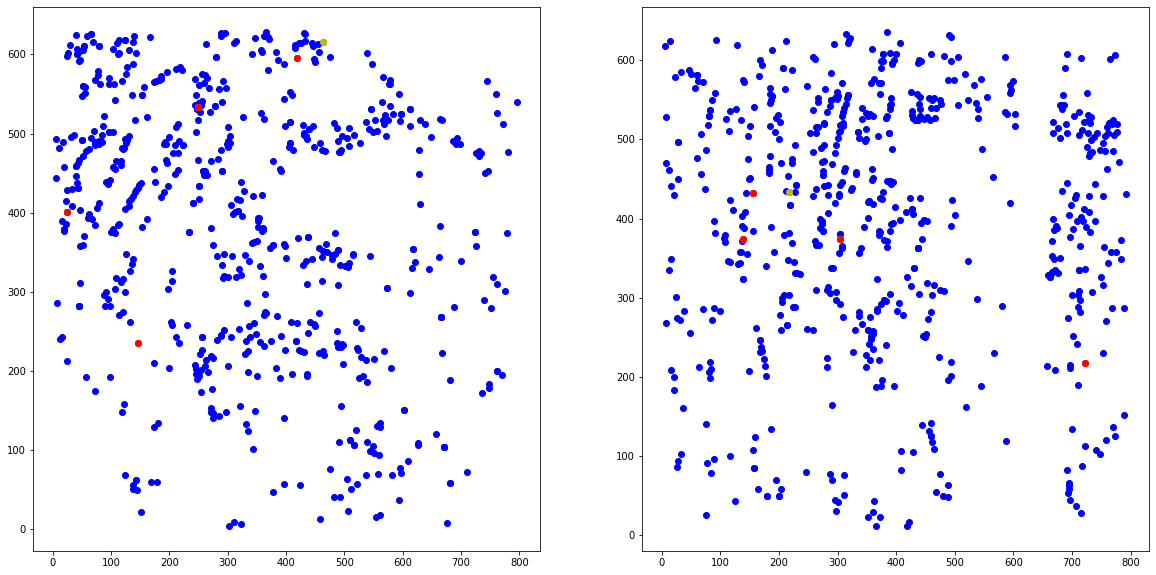

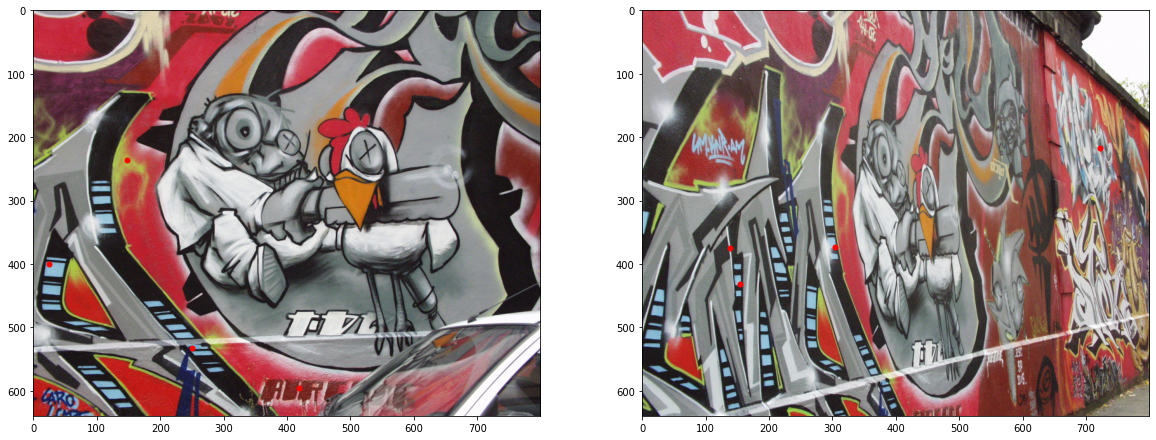

In [16]:
points1, points2 = matched_coordinates(matches, key1, key5)

H, p, indices = RANSAC(matches, key1, key5, 200, 2.5)
inliers1, inliers2 = points1[indices], points2[indices]
img1_h_points, img2_h_points = p[0], p[1] 


fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(points1[:, 0], points1[:, 1], 'bo')
ax[0].plot(inliers1[:, 0], inliers1[:, 1], 'yo')
ax[0].plot(img1_h_points[:, 0], img1_h_points[:, 1], 'ro')

ax[1].plot(points2[:, 0], points2[:, 1], 'bo')
ax[1].plot(inliers2[:, 0], inliers2[:, 1], 'yo')
ax[1].plot(img2_h_points[:, 0], img2_h_points[:, 1], 'ro')

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img1)
ax[0].plot(img1_h_points[:, 0], img1_h_points[:, 1], 'ro', markersize=5)

ax[1].imshow(img5)
ax[1].plot(img2_h_points[:, 0], img2_h_points[:, 1], 'ro', markersize=5)

plt.show()

(c) Stitch img1.ppm onto img5.ppm.

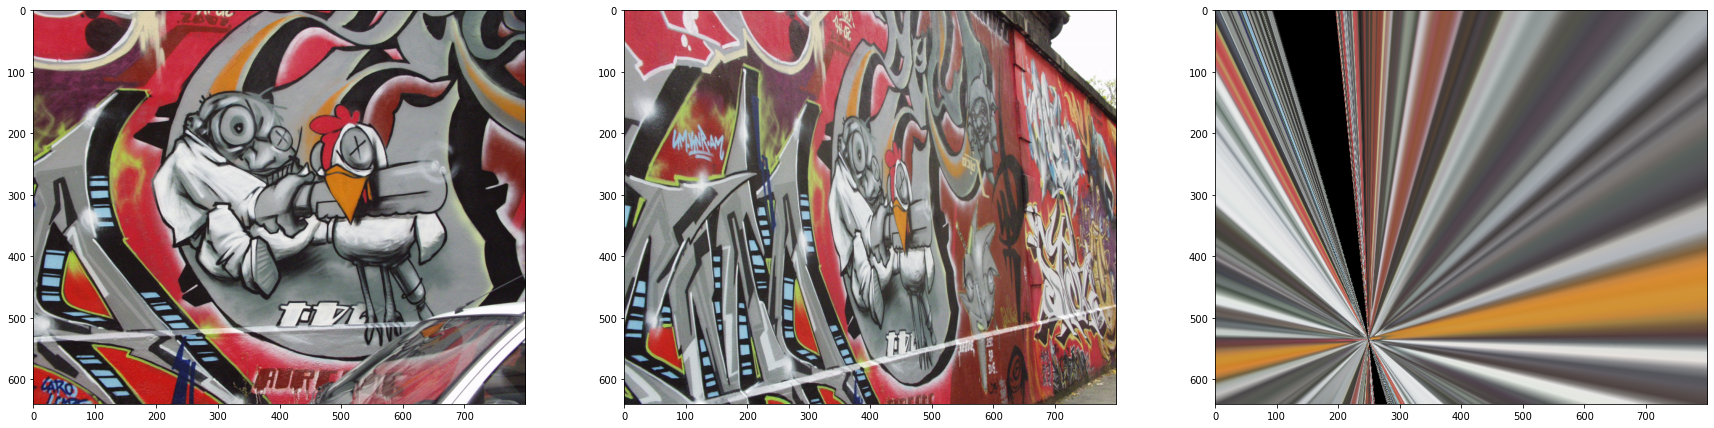

In [15]:
out_img = cv.warpPerspective(img5, np.array(H), (img1.shape[1], img1.shape[0]))

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(img1)
ax[1].imshow(img5)
ax[2].imshow(out_img)

plt.show()